# TensorFlow 2

Interest in neural networks, and in particular those with architechures that support deep learning, has been surging in recent years.

In this notebook we will be revisiting the problem of digit classification on the MNIST data. In doing so, we will introduce a new Machine Learning library, Tensorflow, for working with neural networks. 

Some words to TensorFlow...

In part 1, we'll introduce Tensorflow, and refresh ourselves on the MNIST dataset. In part 2, we'll create a multi-layer neural network with a simple architechure, and train it using backpropagation. Part 3 will introduce the convolutional architechure, which can be said to be doing 'deep learning' (also called feature learning or representation learning).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from IPython.display import display, clear_output 
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import time
import zipfile
%matplotlib inline

In [2]:
mnist = fetch_mldata('MNIST original', data_home='~/Dropbox/MIDS/aTerm_Fall_2017/W207/Data/mnist')
X, Y = mnist.data, mnist.target
X = X / 255.0
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]
numExamples = 2000
test_data, test_labels = X[70000-numExamples:], Y[70000-numExamples:]
train_data, train_labels = X[:numExamples], Y[:numExamples]
numFeatures = train_data[1].size
numClasses = 10
numSamples = train_data.shape[0]
numTestExamples = test_data.shape[0]
print('Features = %d' %(numFeatures))
print('Train set = %d' %(numSamples))
print('Test set = %d' %(numTestExamples))

Features = 784
Train set = 2000
Test set = 2000


#### PART 2: Multi-layer Neural Networks

As we start to get further into Neural Networks, if you'd like to take time on your own for an in-depth introduction on the state of the art in the topic, check out this excellent 1-day tutorial from KDD2014:

Part 1: http://videolectures.net/kdd2014_bengio_deep_learning/

Part 2: http://videolectures.net/tcmm2014_taylor_deep_learning/

10) accuracy = 0.8070


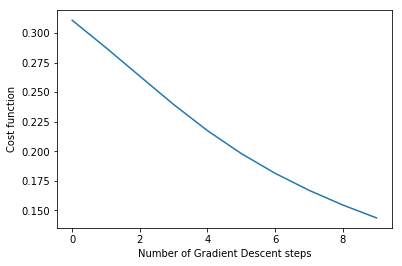

In [3]:
# (1) Parameters
tf.reset_default_graph()

# Constants
testX = tf.constant(test_data, dtype = tf.float32)
hiddenlayer_size = 80
miniBatchSize = 10;

# placeholders
x_ = tf.placeholder(tf.float32, shape=[None, numFeatures], name='x')
y_ = tf.placeholder(tf.int32, shape=[None], name='y')

# and Variables
w1 = tf.get_variable('w1', shape=[numFeatures, hiddenlayer_size])
b1 = tf.get_variable('b1', shape=[hiddenlayer_size])
w2 = tf.get_variable('w2', shape=[hiddenlayer_size, numClasses])
b2 = tf.get_variable('b2', shape=[numClasses])


# (2) Model
def model(input_layer):
    hidden_layer = tf.nn.sigmoid(tf.matmul(input_layer, w1) + b1)
    output_layer = tf.nn.softmax(tf.matmul(hidden_layer, w2) + b2)
    return output_layer

# (3) Cost
def cost(data, labels):
    cc = tf.losses.log_loss(labels, model(data))
    return  cc

# (4) Ojbective (and solver)
y_one_hot = tf.one_hot(y_, numClasses)
cc = cost(x_, y_one_hot)
gd = tf.train.GradientDescentOptimizer(0.1)
step = gd.minimize(cc)
test_preds = model(testX)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    cost_vec = []
    for i in range(10):
        for start, end in zip(range(0, numSamples, miniBatchSize), range(miniBatchSize, numSamples, miniBatchSize)):
            batch = train_data[start:end], train_labels[start:end]
            _, cost, test__preds = sess.run([step, cc, test_preds], feed_dict={x_: batch[0], y_: batch[1]})
        cost_vec.append(cost)
        clear_output(wait=True)
        print('%d) accuracy = %.4f' %(i+1, np.mean(np.argmax(test__preds, axis=1) == test_labels)))
    
plt.plot(cost_vec)  
plt.xlabel('Number of Gradient Descent steps')
plt.ylabel('Cost function')
plt.show()

Exercise: Change the number of nodes in the hidden layer?  What do you expect the impact to be?  What is the impact?


As interest in networks with more layers and more complicated architechures has increased, a couple of tricks have emerged and become standard practice.  Let's look at two of those--rectifier activation and dropout noise.

Exercise:  We saw an improvement from adding a hidden layer.  What do you expect to happen if a second hidden layer was added?  

Let's try it...

In [ ]:

#### YOUR CODE HERE


#### Activation Revisted

Let's look at a recent idea around activation closely associated with deep learning.  In 2010, in a paper published at NIPS (https://www.utc.fr/~bordesan/dokuwiki/_media/en/glorot10nipsworkshop.pdf), Yoshua Bengio showed that rectifier activation works better empirically than sigmoid activation when used in the hidden layers.  

The rectifier activation is simple: f(x)=max(0,x).  Intuitively, the difference is that as a sigmoid activated node approaches 1 it stops learning even if error continues to be propagated to it, whereas the rectifier activated node continue to learn (at least in the positive direction).  It is not completely understood (per Yoshua Bengio) why this helps, but there are some theories being explored including as related to the benefits of sparse representations in networks. (http://www.iro.umontreal.ca/~bengioy/talks/KDD2014-tutorial.pdf).  Rectifiers also speed up training.

Although the paper was published in 2010, the technique didn't gain widespread adoption until 2012 when members of Hinton's group spread the word, including with this Kaggle entry: http://blog.kaggle.com/2012/11/01/deep-learning-how-i-did-it-merck-1st-place-interview/

In TensorFlow the rectifier activation is implemented by the function tf.nn.relu().
Let's change the activation in our 2 layer network to rectifier and see what happens...

In [ ]:

### YOUR CODE HERE ###


#### Maxout Activation

So rectifier activation worked great!  

Exercise: try another type of activation called Maxout (or Max Pooling) activiation.  Maxout activation just selects the max input as the output.  Maxout is a type of pooling, a technique which performs particularly well for vision problems. For more background see: http://jmlr.org/proceedings/papers/v28/goodfellow13.pdf and http://www.quora.com/What-is-impact-of-different-pooling-methods-in-convolutional-neural-networks  

#### Noise

Previously when working with the MNIST data we saw a benefit in generalization from adding noise to the training data.  Let's try that again here, however this time with a trick for adding noise called 'Dropouts'.  The idea with dropouts is that instead of (or in addition to) adding noise to our inputs, we add noise by having each node return 0 with a certain probability during training.  This trick both improves generalization in large networks and speeds up training.

Hinton introduced the idea in 2012 and gave an explanation of why it's similar to bagging (http://arxiv.org/pdf/1207.0580v1.pdf)

Let's give it a try...

25) accuracy = 0.9115


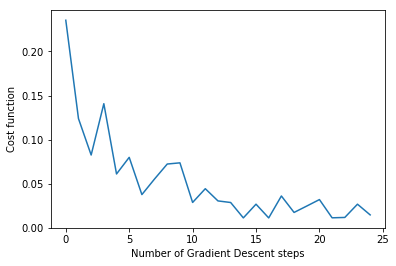

In [5]:
# (1) Parameters
tf.reset_default_graph()

# Constants
testX = tf.constant(test_data, dtype = tf.float32)
hiddenlayer_size = 120
p_keep1 = 0.8
p_keep2 = 0.6
miniBatchSize = 10;

# placeholders
x_ = tf.placeholder(tf.float32, shape=[None, numFeatures], name='x')
y_ = tf.placeholder(tf.int32, shape=[None], name='y')

# and Variables
w1 = tf.get_variable('w1', shape=[numFeatures, hiddenlayer_size])
b1 = tf.get_variable('b1', shape=[hiddenlayer_size])
w2 = tf.get_variable('w2', shape=[hiddenlayer_size, numClasses])
b2 = tf.get_variable('b2', shape=[numClasses])


# (2) Model
def model(input_layer, is_training = True):
    if is_training:
        pk1 = p_keep1
        pk2 = p_keep2
    else:
        pk1 = 1
        pk2 = 1
    hidden_layer = tf.nn.relu(tf.matmul(tf.nn.dropout(input_layer, pk1), w1) + b1)
    output_layer = tf.nn.softmax(tf.matmul(tf.nn.dropout(hidden_layer, pk2), w2) + b2)
    return output_layer

# (3) Cost
def cost(data, labels):
    cc = tf.losses.log_loss(labels, model(data))
    return  cc

# (4) Ojbective (and solver)
y_one_hot = tf.one_hot(y_, numClasses)
cc = cost(x_, y_one_hot)
gd = tf.train.GradientDescentOptimizer(0.1)
step = gd.minimize(cc)
test_preds = model(testX, is_training = False)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    cost_vec = []
    for i in range(25):
        for start, end in zip(range(0, numSamples, miniBatchSize), range(miniBatchSize, numSamples, miniBatchSize)):
            batch = train_data[start:end], train_labels[start:end]
            _, cost, test__preds = sess.run([step, cc, test_preds], feed_dict={x_: batch[0], y_: batch[1]})
        cost_vec.append(cost)
        clear_output(wait=True)
        print('%d) accuracy = %.4f' %(i+1, np.mean(np.argmax(test__preds, axis=1) == test_labels)))
    
plt.plot(cost_vec)  
plt.xlabel('Number of Gradient Descent steps')
plt.ylabel('Cost function')
plt.show()

#### Part 3: Convolutional Neural Nets

Today, when the phrase 'deep learning' is used to describe a system, it is often a convolution neural network (or convonet).  The convonet architechture was largely developed in the late 90's at Bell Labs, but only very recently popularized.  It was developed for image recognition, and is described and implemented with 2d representations in mind.

Geoffrey Hinton has an excellent two-part lecture on the topic:

https://www.youtube.com/watch?v=6oD3t6u5EPs

https://www.youtube.com/watch?v=fueIAeAsGzA

Also, this code was partly taken from these tutorials, which are worth referring back to:

http://deeplearning.net/tutorial/lenet.html

http://ufldl.stanford.edu/tutorial/supervised/FeatureExtractionUsingConvolution/

https://www.youtube.com/watch?v=S75EdAcXHKk

http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/

In [ ]:
# (1) Parameters
tf.reset_default_graph()

# Constants
image_size = int(np.sqrt(numFeatures))   # numFeatures should be a square number
p_keep1 = 0.8
p_keep2 = 0.6
p_keep3 = 0.6
hiddenlayer_size = 120
filter_size = 5
depth_size = 3
mp_size = 2
miniBatchSize = 20;
testX = tf.constant(test_data, dtype = tf.float32)

# placeholders
x_ = tf.placeholder(tf.float32, shape=[None, numFeatures], name='x')
y_ = tf.placeholder(tf.int32, shape=[None], name='y')

# and Variables
w1 = tf.get_variable('w1', shape=[filter_size, filter_size, 1, depth_size])
w2 = tf.get_variable('w2', shape=[int(image_size/mp_size*image_size/mp_size*depth_size), hiddenlayer_size])
b2 = tf.get_variable('b2', shape=[hiddenlayer_size])
w3 = tf.get_variable('w3', shape=[hiddenlayer_size, numClasses])
b3 = tf.get_variable('b3', shape=[numClasses])


# (2) Model
def model(input_layer, is_training = True):
    if is_training:
        pk1 = p_keep1
        pk2 = p_keep2
        pk3 = p_keep3
    else:
        pk1 = 1
        pk2 = 1
        pk3 = 1
        
    l1 = tf.reshape(input_layer, [-1, image_size, image_size, 1])
    l2 = tf.nn.dropout(l1, pk1)
    l3 = tf.nn.conv2d(l2, w1, [1,1,1,1], 'SAME')
    l4 = tf.nn.relu(l3)
    l5 = tf.nn.max_pool(l4, [1,mp_size, mp_size, 1], [1, mp_size, mp_size,1], 'VALID')
    
    l6 = tf.reshape(l5, [-1, int(image_size/mp_size*image_size/mp_size*depth_size)])
    l7 = tf.nn.dropout(l6, pk2)
    l8 = tf.matmul(l7, w2) + b2
    l9 = tf.nn.relu(l8)
    
    l10 = tf.nn.dropout(l9, pk3)
    l11 = tf.matmul(l10, w3) + b3
    output_layer = tf.nn.softmax(l11)
    return output_layer

# (3) Cost
def cost(data, labels):
    cc = tf.losses.log_loss(labels, model(data))
    return  cc

# (4) Ojbective (and solver)
y_one_hot = tf.one_hot(y_, numClasses)
cc = cost(x_, y_one_hot)
gd = tf.train.GradientDescentOptimizer(0.1)
step = gd.minimize(cc)
test_preds = model(testX, is_training = False)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    cost_vec = []
    for i in range(5):
        for start, end in zip(range(0, numSamples, miniBatchSize), range(miniBatchSize, numSamples, miniBatchSize)):
            batch = train_data[start:end], train_labels[start:end]
            _, cost, test__preds = sess.run([step, cc, test_preds], feed_dict={x_: batch[0], y_: batch[1]})
        cost_vec.append(cost)
        clear_output(wait=True)
        print('%d) accuracy = %.4f' %(i+1, np.mean(np.argmax(test__preds, axis=1) == test_labels)))
    
plt.plot(cost_vec)  
plt.xlabel('Number of Gradient Descent steps')
plt.ylabel('Cost function')
plt.show()

In the last cell we use the predefined layers provided by Tensorflow. In this case, we do not need to define the variables by ourselves, but TensorFlow creates the variables for us.
Check this out:
https://www.tensorflow.org/tutorials/layers

In [ ]:
# (1) Parameters
tf.reset_default_graph()

# Constants
image_size = int(np.sqrt(numFeatures))   # numFeatures should be a square number
p_keep1 = 0.8
p_keep2 = 0.6
p_keep3 = 0.6
hiddenlayer_size = 120
filter_size = 5
depth_size = 3
mp_size = 2
miniBatchSize = 20

# placeholders
x_ = tf.placeholder(tf.float32, shape=[None, numFeatures], name='x')
y_ = tf.placeholder(tf.int32, shape=[None], name='y')
is_training_ = tf.placeholder_with_default(True, shape=[], name='is_training')


# (2) Model
def model(input_layer, is_training):
    l1 = tf.reshape(input_layer, [-1, image_size, image_size, 1])
    l2 = tf.layers.dropout(inputs = l1,
                          rate = 1-p_keep1,
                          training = is_training)
    l3 = tf.layers.conv2d(inputs = l2, 
                         filters = depth_size, 
                         kernel_size = [filter_size, filter_size], 
                         padding='same', 
                         activation=tf.nn.relu)
    l4 = tf.layers.max_pooling2d(inputs = l3, 
                                pool_size = [mp_size, mp_size], 
                                strides = mp_size)
    l5 = tf.reshape(l4, [-1, int(image_size/mp_size * image_size/mp_size * depth_size)])
    l6 = tf.layers.dropout(inputs = l5,
                          rate = 1-p_keep2,
                          training = is_training)
    l7 = tf.layers.dense(inputs = l6, 
                        units = hiddenlayer_size,
                        activation = tf.nn.relu)
    l8 = tf.layers.dropout(inputs = l7,
                          rate = 1-p_keep2,
                          training = is_training)
    l9 = tf.layers.dense(inputs = l8, 
                        units = hiddenlayer_size,
                        activation = tf.nn.relu)
    l10 = tf.layers.dropout(inputs = l9,
                          rate = 1-p_keep3,
                          training = is_training)
    output_layer = tf.layers.dense(inputs = l10,
                        units = numClasses,
                        activation = tf.nn.softmax)
    return output_layer


# (4) Ojbective (and solver)
y_one_hot = tf.one_hot(y_, numClasses)
preds = model(x_, is_training_)
cc = tf.losses.log_loss(y_one_hot, preds)
gd = tf.train.GradientDescentOptimizer(0.1)
step = gd.minimize(cc)

# (5) Use model to calculate accuracy
acc = tf.metrics.accuracy(y_, tf.argmax(preds, axis=1))[1]


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    cost_vec = []
    acc_test_vec = []
    acc_train_vec = []
    for i in range(100):
        for start, end in zip(range(0, numSamples, miniBatchSize), range(miniBatchSize, numSamples, miniBatchSize)):
            batch = train_data[start:end], train_labels[start:end]
            _, cost = sess.run([step, cc], feed_dict={x_: batch[0], y_: batch[1], is_training_: True})
            
        test_acc = acc.eval(feed_dict={x_: test_data, y_: test_labels, is_training_: False})
        train_acc = acc.eval(feed_dict={x_: train_data, y_: train_labels, is_training_: False})
              
        cost_vec.append(cost)
        clear_output(wait=True)
        acc_test_vec.append(test_acc)
        acc_train_vec.append(train_acc)
        print('%d) accuracy = %.4f' %(i+1, test_acc))
    
plt.plot(cost_vec)  
plt.xlabel('Number of Gradient Descent steps')
plt.ylabel('Cost function')
plt.show()

plt.plot(acc_test_vec)  
plt.plot(acc_train_vec)
plt.xlabel('Number of Gradient Descent steps')
plt.ylabel('Train and Test Accuracy')
plt.show()

57) accuracy = 0.8843
